# Import pacakges

In [1]:
from WEB import *
import numpy as np
from tqdm import tqdm

# Simulation

## Simple simulation (contaminated ratio = 0.2)

In [2]:
START_RAD = 0
MAX_RAD = 1
GAP = 0.2

### Create data

In [6]:
web = WEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
_ = web.create_data(
            group_num=2, 
            group_name=["A", "B"], 
            contained_ratio_data=0.2, 
            contained_ratio_beta=0.2, 
            points_num = 100, 
            in_group_num=5, 
            contaminated_beta0_within_group = -4, 
            contaminated_beta1_within_group = 4
            )

### Fit our model

In [7]:
_ = web.paramters_initial()
betas_WEB, histories = web.WEB_iter_test2(max_iter=20, alpha=0.5, gamma=0.5, verbose=0)

100%|██████████| 2/2 [00:00<00:00, 37.78it/s]


### Plot results

<Figure size 640x480 with 0 Axes>

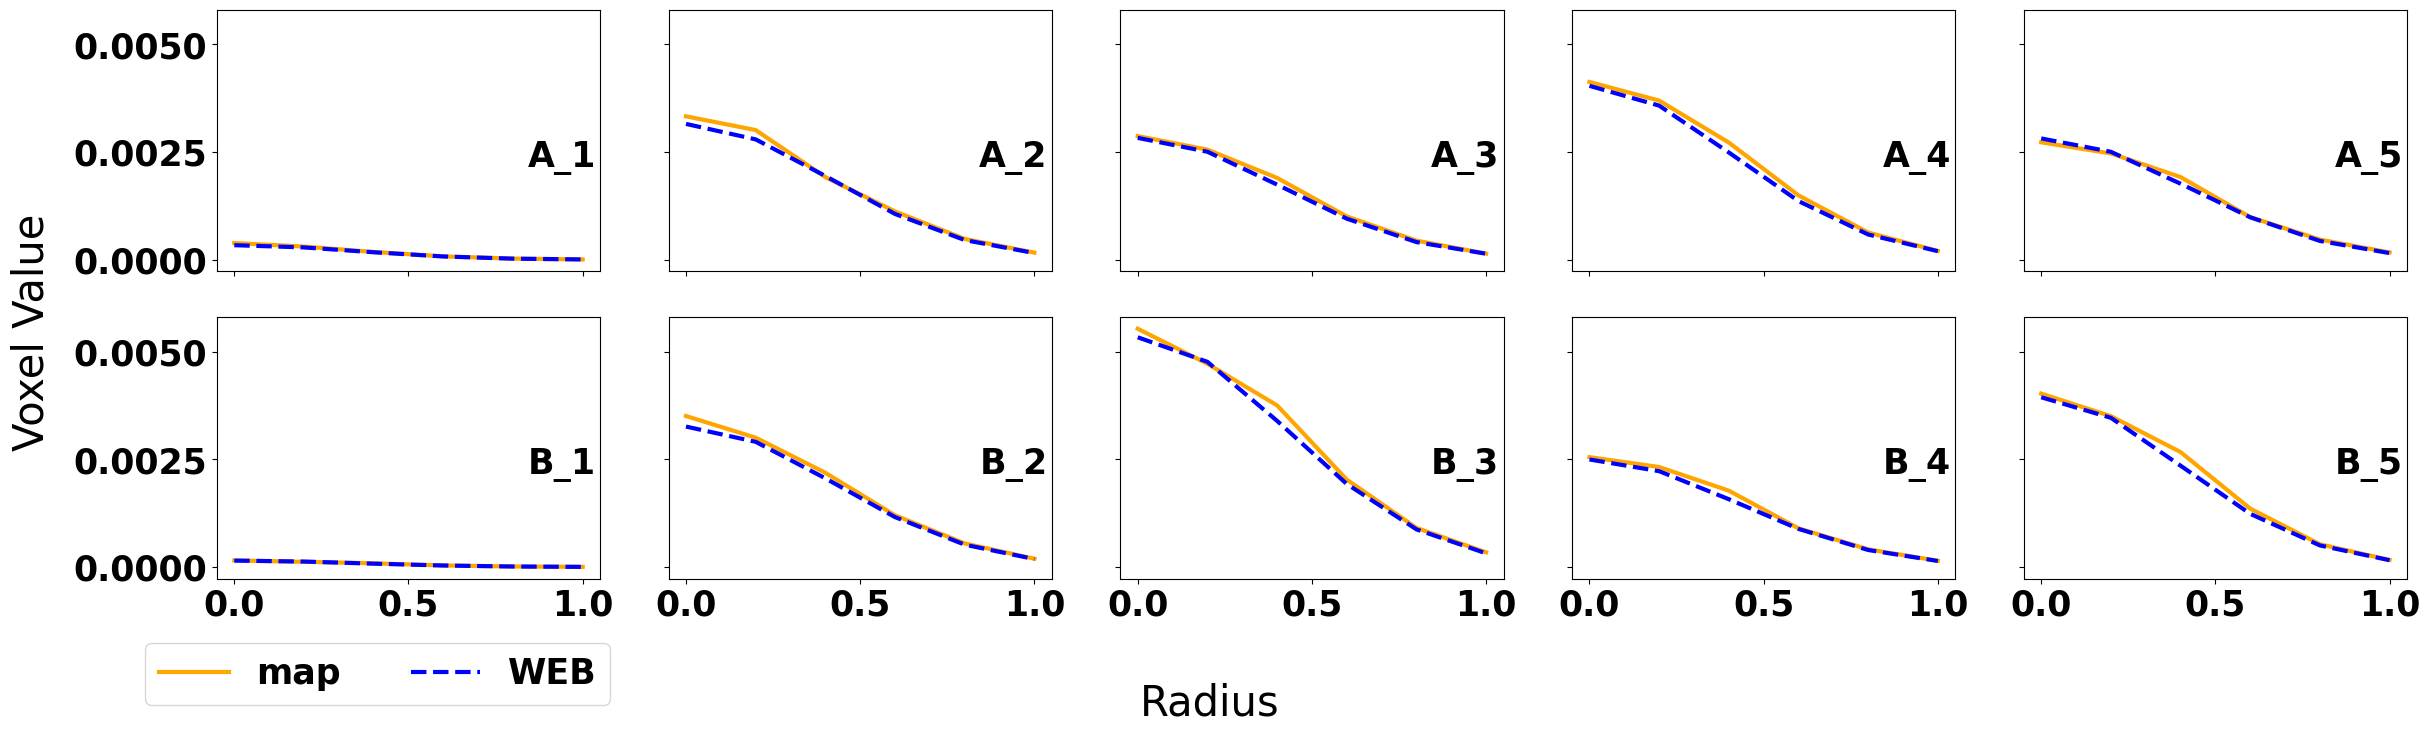

In [8]:
web.fitted_densities_plot(["A", "B"], f"./figures/simulation")

### Generalized simulation (contaminated ratio change)

### Initial value

In [6]:
NUM = 8
IN_GROUP_NUM = 50

### Create data and fit our model

In [7]:
mse_0_WEB = np.zeros((NUM, NUM))
mse_1_WEB = np.zeros((NUM, NUM))
mse_hyper_WEB = np.zeros((NUM, NUM))

web = WEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
for i in tqdm(range(NUM)):
    contained_ratio_beta = 0.05 * i
    for j in range(NUM):
        contained_ratio_data = 0.05 * j
        web.create_data(
            group_num=1, 
            group_name=["A"], 
            contained_ratio_data=contained_ratio_data, 
            contained_ratio_beta=contained_ratio_beta, 
            in_group_num=IN_GROUP_NUM
            )
        web.paramters_initial()
        web.WEB_iter_test2(max_iter=20, alpha=0.5, gamma=0.5, verbose=False)
        
        mse_0_WEB[i][j], mse_1_WEB[i][j] = np.mean((web.betas["A"] - web.betas_WEB["A"])**2, axis=0)
        mse_hyper_WEB[i][j] = np.sum((web.mus["A"] - web.mus_mle["A"])**2) / 2

100%|██████████| 8/8 [15:32<00:00, 116.55s/it]


### Plot Results

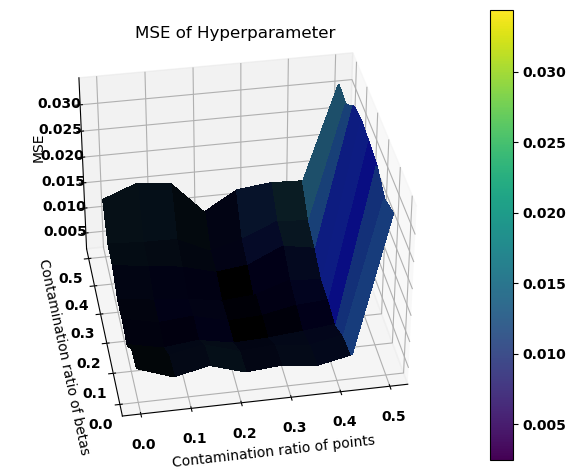

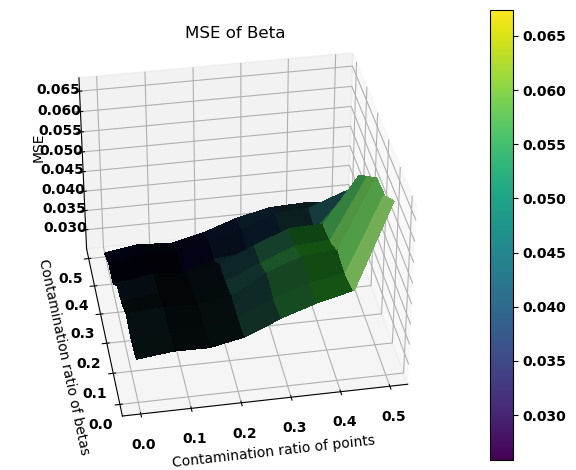

In [8]:
simulation_plot(mse_hyper_WEB, "MSE", "MSE of Hyperparameter")
simulation_plot(mse_0_WEB + mse_1_WEB, "MSE", "MSE of Beta")

In [11]:
sum(web.weights["A"][0])

315.7116392790007

In [12]:
len(web.data_log["A"])

50

In [ ]:
import pandas as pd
import category_encoders as ce
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from utils import *


def get_adj_MRT(df):
    target_df = pd.read_csv('./external_data/捷運站點資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate MRT distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))
    
    df['MRT_distance'] = min_distance
    return df

def get_adj_postoff(df):
    target_df = pd.read_csv('./external_data/郵局據點資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Postoffice distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))
    
    df['postoffice_distance'] = min_distance
    return df

def get_adj_bus(df, thresh=2):
    target_df = pd.read_csv('./external_data/公車站點資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Bus distance...')
    adj_dict=defaultdict(list)
    for i in tqdm(range(Xpoints.shape[0]),total = Xpoints.shape[0]):
        x = [Xpoints[i,0]]*len(Ypoints)
        y = [Xpoints[i,1]]*len(Ypoints)
        distances = np.array(haversine_np(x,y,Ypoints[:,0],Ypoints[:,1]))
        adj_dict['bus_distance'].append(np.min(distances))
        adj_dict['bus_num'].append(np.sum(distances<thresh))
    for k,v in adj_dict.items():
        df[k] = v
    return df

def get_adj_school(df):
    # primary school
    target_df = pd.read_csv('./external_data/國小基本資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Primary school distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))
    df['primary_school_distance'] = min_distance
    
    # junior school
    target_df = pd.read_csv('./external_data/國中基本資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Junior school distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))
    df['junior_school_distance'] = min_distance
    
    # high school
    target_df = pd.read_csv('./external_data/高中基本資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate High school distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))
    df['high_school_distance'] = min_distance
    
    target_df = pd.read_csv('./external_data/大學基本資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate University school distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))

    df['university_school_distance'] = min_distance
    
    df['adj_school'] = df.eval('university_school_distance<1 | high_school_distance<1 | junior_school_distance<1 | primary_school_distance <1')
    return df


# def get_adj_school(df):
#     # primary school
#     target_df = pd.read_csv('./external_data/國小基本資料.csv')
#     student_num = target_df[list(filter(lambda x: "學生數" in x, target_df.columns))].sum(axis=1)
#     Xpoints = df[['橫坐標','縱坐標']].values
#     Ypoints = target_df[['lat','lng']].values
#     print('calculate Primary school distance...')
#     distance_table=calculate_haversine_distance(Xpoints,Ypoints)
#     student_nums_in_thresh = (student_num.values * (distance_table < thresh)).sum(axis=1)
#     min_distance=[]
#     min_distance_student_num=[]
#     student_num_in_thresh = []
#     for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
#         min_distance.append(np.min(distance_table[i]))
#         min_distance_student_num.append(student_num[distance_table[i].argmin()])
#         student_num_in_thresh.append(student_nums_in_thresh[i])
#     df['primary_school_distance'] = min_distance
#     df['primary_school_student_num'] = min_distance_student_num
#     df['primary_school_student_num_in_thresh'] = student_num_in_thresh
    
#     # junior school
#     target_df = pd.read_csv('./external_data/國中基本資料.csv')
#     student_num = target_df[list(filter(lambda x: "學生數" in x, target_df.columns))].sum(axis=1)
#     Xpoints = df[['橫坐標','縱坐標']].values
#     Ypoints = target_df[['lat','lng']].values
#     print('calculate Junior school distance...')
#     distance_table=calculate_haversine_distance(Xpoints,Ypoints)
#     student_nums_in_thresh = (student_num.values * (distance_table < thresh)).sum(axis=1)
#     min_distance=[]
#     min_distance_student_num=[]
#     student_num_in_thresh = []
#     for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
#         min_distance.append(np.min(distance_table[i]))
#         min_distance_student_num.append(student_num[distance_table[i].argmin()])
#         student_num_in_thresh.append(student_nums_in_thresh[i])
#     df['junior_school_distance'] = min_distance
#     df['junior_school_student_num'] = min_distance_student_num
#     df['junior_school_student_num_in_thresh'] = student_num_in_thresh
    
#     # high school
#     target_df = pd.read_csv('./external_data/高中基本資料.csv')
#     student_num = target_df[list(filter(lambda x: "學生數" in x, target_df.columns))].sum(axis=1)
#     Xpoints = df[['橫坐標','縱坐標']].values
#     Ypoints = target_df[['lat','lng']].values
#     print('calculate High school distance...')
#     distance_table=calculate_haversine_distance(Xpoints,Ypoints)
#     student_nums_in_thresh = (student_num.values * (distance_table < thresh)).sum(axis=1)
#     min_distance=[]
#     min_distance_student_num=[]
#     student_num_in_thresh = []
#     for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
#         min_distance.append(np.min(distance_table[i]))
#         min_distance_student_num.append(student_num[distance_table[i].argmin()])
#         student_num_in_thresh.append(student_nums_in_thresh[i])
#     df['high_school_distance'] = min_distance
#     df['high_school_student_num'] = min_distance_student_num
#     df['high_school_student_num_in_thresh'] = student_num_in_thresh
    
#     # university school     
#     target_df = pd.read_csv('./external_data/大學基本資料.csv')
#     student_num = target_df[list(filter(lambda x: "計" in x, target_df.columns))].sum(axis=1)
#     Xpoints = df[['橫坐標','縱坐標']].values
#     Ypoints = target_df[['lat','lng']].values
#     print('calculate University school distance...')
#     distance_table=calculate_haversine_distance(Xpoints,Ypoints)
#     student_nums_in_thresh = (student_num.values * (distance_table < thresh)).sum(axis=1)
#     min_distance=[]
#     min_distance_student_num=[]
#     student_num_in_thresh = []
#     for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
#         min_distance.append(np.min(distance_table[i]))
#         min_distance_student_num.append(student_num[distance_table[i].argmin()])
#         student_num_in_thresh.append(student_nums_in_thresh[i])
#     df['university_school_distance'] = min_distance
#     df['university_school_student_num'] = min_distance_student_num
#     df['university_school_student_num_in_thresh'] = student_num_in_thresh
    
#     df['adj_school'] = df.eval('university_school_distance<1 | high_school_distance<1 | junior_school_distance<1 | primary_school_distance <1')
#     return df


def get_adj_train(df):
    target_df = pd.read_csv('./external_data/火車站點資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Train distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    min_distance=[]
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        min_distance.append(np.min(distance_table[i]))

    df['train_distance'] = min_distance
    return df

def get_adj_shop(df,thresh=2):
    target_df = pd.read_csv('./external_data/火車站點資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Shop distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    adj_dict=defaultdict(list)
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        adj_dict['shop_distance'].append(np.min(distance_table[i]))
        adj_dict['shop_num'].append(np.sum(distance_table[i]<thresh))
    for k,v in adj_dict.items():
        df[k] = v
    return df

def get_adj_hospital(df,thresh=5):
    target_df = pd.read_csv('./external_data/醫療機構基本資料.csv')
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = target_df[['lat','lng']].values
    print('calculate Hospital distance...')
    distance_table=calculate_haversine_distance(Xpoints,Ypoints)
    adj_dict=defaultdict(list)
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        adj_dict['hospital_distance'].append(np.min(distance_table[i]))
        adj_dict['hospital_num'].append(np.sum(distance_table[i]<thresh))
    for k,v in adj_dict.items():
        df[k] = v
    return df

def get_adj_info(df,thresh=1):
    """
    thresh -> km
    """
    data_df = df[df.Set == 'Train']
    Xpoints = df[['橫坐標','縱坐標']].values
    Ypoints = data_df[['橫坐標','縱坐標']].values
    print('calculate sample distance...')
    distance_table=calculate_haversine_distance(Xpoints, Ypoints)
    adj_dict=defaultdict(list)
    print('calculate adjacency sample...')
    prices = data_df['residual_price'].values
    house_age = data_df['屋齡'].values
    house_volumes = data_df['建物面積'].values
    house_height = data_df['總樓層數'].values
    for i in tqdm(range(distance_table.shape[0]),total = distance_table.shape[0]):
        if i< distance_table.shape[1]:
            distance_table[i][i] = np.inf
        indexs = np.where(distance_table[i]<thresh)[0]
        if len(indexs)>0:
            indexs = indexs[indexs!= i]
        else:
            indexs = [distance_table[i].argmin()]

        adj_mean = np.median(prices[indexs])
        adj_dict['adj_min'].append(np.min(prices[indexs]))
        adj_dict['adj_max'].append(np.max(prices[indexs]))
        adj_dict['adj_std'].append(np.std(prices[indexs]))
        adj_dict['adj_num'].append(len(indexs))
        adj_dict['adj_price'].append(adj_mean)
        adj_dict['adj_distance'].append(np.mean(distance_table[i][indexs]))
        adj_dict['adj_house_age_median'].append(np.median(house_age[indexs]))
        adj_dict['adj_house_age_std'].append(np.std(house_age[indexs]))
        adj_dict['adj_house_volume_median'].append(np.median(house_volumes[indexs]))
        adj_dict['adj_house_volume_std'].append(np.std(house_volumes[indexs]))
        adj_dict['adj_house_height_median'].append(np.median(house_height[indexs]))
        adj_dict['adj_house_height_std'].append(np.std(house_height[indexs]))
        
    for k,v in adj_dict.items():
        df[k] = v

    return df

def merge_feature(df):
    df.loc[df['主要建材'].isin(['磚造', '鋼筋混凝土加強磚造']),'主要建材'] = '其他'
    return df

def target_category_processing(df:pd.DataFrame):
    # target encoding
    train_df = df[df.Set == 'Train']
    JS_encoder = ce.JamesSteinEncoder()
    JS_encoder.fit(train_df[['鄉鎮市區']],train_df['residual_price'])
    df['鄉鎮市區_encode'] = JS_encoder.transform(df[['鄉鎮市區']]).values 

    for city in train_df['縣市'].unique():
        for town in train_df.query(f'縣市 == "{city}"')['鄉鎮市區'].unique():
            JS_encoder = ce.JamesSteinEncoder()
            JS_encoder.fit(train_df.loc[(train_df['鄉鎮市區'] == town) & (train_df['縣市'] == city),['主要建材','主要用途','電梯']],train_df.loc[(train_df['鄉鎮市區'] == town) & (train_df['縣市'] == city),'residual_price'])
            df.loc[(df['鄉鎮市區'] == town) & (df['縣市'] == city),['主要建材_encode','主要用途_encode','電梯_encode']] = JS_encoder.transform(df.loc[(df['鄉鎮市區'] == town) & (df['縣市'] == city),['主要建材','主要用途','電梯']]).values 
    
    return df


def feature_engineer_processing(df:pd.DataFrame):
    """
    df -> all data (public, valid, train, private)
    """
    
    df = merge_feature(df)
    
    df['電梯'] = df['建物型態'].apply(lambda x: '有電梯' in x).astype(int)
    df['車位'] = df['車位個數'].apply(lambda x: x>0)
    df['陽台'] = df['陽台面積'].apply(lambda x :x != df['陽台面積'].min())
    df['建物型態'] = df['建物型態'].apply(lambda x: x[:x.find('(')])
    df['頂樓'] = df['總樓層數'] == df['移轉層次']
    df['頂樓差'] = df['總樓層數'] - df['移轉層次']
    df['鄉鎮平均屋齡'] = df.groupby(['縣市','鄉鎮市區'])['屋齡'].transform(lambda x: x.median())
    df['鄉鎮平均建物面積'] = df.groupby(['縣市','鄉鎮市區'])['建物面積'].transform(lambda x: x.median())
    df['鄉鎮平均樓高'] = df.groupby(['縣市','鄉鎮市區'])['總樓層數'].transform(lambda x: x.median())
    df['屋齡差'] = df['屋齡'] - df['鄉鎮平均屋齡']
    df['建物面積差'] = df['建物面積'] - df['鄉鎮平均建物面積']
    df['總樓層數差'] = df['總樓層數'] - df['鄉鎮平均樓高']
    
    #座標轉換
    new_locations =[]
    locations = df[['橫坐標','縱坐標']].values
    for i in range(len(df)):
        _x, _y = locations[i]
        x,y = convert_twd97_to_wgs84(_x, _y)
        new_locations.append([x,y])
    df[['橫坐標','縱坐標']] = new_locations
    
    # Category
    df['商用途'] = df['使用分區'].apply(lambda x: x == '商')
    df['工用途'] = df['使用分區'].apply(lambda x: x == '工')
    df['農用途'] = df['使用分區'].apply(lambda x: x == '農')
    df['diff_面積'] = df['建物面積'] - df['主建物面積']
    df['台北'] = df['縣市'].apply(lambda x: '台北' in x)
    df['新北'] = df['縣市'].apply(lambda x: '新北' in x)
    df['新竹'] = df['縣市'].apply(lambda x: '新竹' in x) 
    df['高雄'] = df['縣市'].apply(lambda x: '高雄' in x)    
    df['直轄市'] = df['縣市'].apply(lambda x: '新竹' in x or '台北' in x or '新北' in x or '高雄' in x or '台中' in x or '台南' in x)
    
    # get adjacency sample
    df = get_adj_MRT(df)
    df = get_adj_train(df)
    df = get_adj_shop(df, thresh=0.5)    
    # df = get_adj_bus(df, thresh=0.5)
    df = get_adj_postoff(df)
    df = get_adj_hospital(df, thresh=0.5)
    df = get_adj_school(df)
    
    # one hot encoding
    one_hot_cols=['建物型態','主要建材','主要用途','縣市']
    for col in one_hot_cols:
        _valuse = df[col].values
        df = pd.get_dummies(df,columns=[col])
        df[col] = _valuse
        
    return df
    
def feature_processing(df:pd.DataFrame, adj_thresh = 1):
    
    # Label Processing
    _df = df[df.Set == 'Train']
    df.loc[df.Set == 'Train','單價'] = np.log(_df['單價'])

    # Residual Price Processing 
    df['city_town_median']= df.groupby(['縣市','鄉鎮市區'])[['單價']].transform(lambda x: x.median())
    df['city_median']= df.groupby(['縣市'])[['單價']].transform(lambda x: x.median())
    df.loc[df['city_town_median'].isna(),'city_town_median']= df.loc[df['city_town_median'].isna(),'city_median'].values

    df.loc[df.Set == 'Train','residual_price'] = df.loc[df.Set == 'Train','單價'] - df.loc[df.Set == 'Train','city_median']
    df['residual_price'] = df['residual_price'].apply(lambda x: x+ np.random.normal(1e-5,1e-6)*np.random.choice([-1,1]))
    
    df['city_residual_min']= df.groupby(['縣市'])[['residual_price']].transform(lambda x: x.min())
    df['city_residual_max']= df.groupby(['縣市'])[['residual_price']].transform(lambda x: x.max())
    df['city_residual_std']= df.groupby(['縣市'])[['residual_price']].transform(lambda x: x.std())
    df['city_town_residual_median']= df.groupby(['縣市','鄉鎮市區'])[['residual_price']].transform(lambda x: x.median())
    df['city_town_residual_min']= df.groupby(['縣市','鄉鎮市區'])[['residual_price']].transform(lambda x: x.min())
    df['city_town_residual_max']= df.groupby(['縣市','鄉鎮市區'])[['residual_price']].transform(lambda x: x.max())
    df['city_town_residual_std']= df.groupby(['縣市','鄉鎮市區'])[['residual_price']].transform(lambda x: x.std())
    df = get_adj_info(df,thresh=0.5)
    
    # Target Encoder
    df = target_category_processing(df)
    
    
    # feature columns
    drop_columns=['備註','路名','縣市','單價','使用分區','主要用途','主要建材','鄉鎮市區','ID','Set','建物型態','residual_price','city_town_median','city_median','city_min','city_max','city_std']
    feature_columns = df.columns
    for c in drop_columns:
        if c in feature_columns:
            feature_columns = feature_columns.drop(c)
            continue
    
    return df, feature_columns
    

